In [3]:
%load_ext autoreload
%autoreload 2

## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [8]:
# load some helper utils for running for long time
if not os.path.isfile('workspace_utils.py'):
    !curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py
from workspace_utils import active_session

## Create your training and testing data:

In [22]:
from source.train import _create_dataset
create_new_trainval_set = 0
input_file = '/data/Data_Entry_2017.csv'
output_trainfile = os.path.join('processed_data', 'train_data.csv')
output_valfile = os.path.join('processed_data', 'val_data.csv') 
if create_new_trainval_set:
    _create_dataset(input_file = input_file,
                       output_trainfile = output_trainfile,
                    output_valfile = output_valfile)
train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)

Scans found: 112120 , Total Headers 112120


## Create your training and testing data:

In [5]:
from source.train import create_splits
dev_flag = 0
if dev_flag:
    train_data = train_data.sample(1500)
    val_data = val_data.sample(1500)

#### First suggestion: perform some image augmentation on your data

In [6]:
from source.train import TrainGen, make_val_gen
train_gen = TrainGen(train_data)
val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')

Found 2304 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


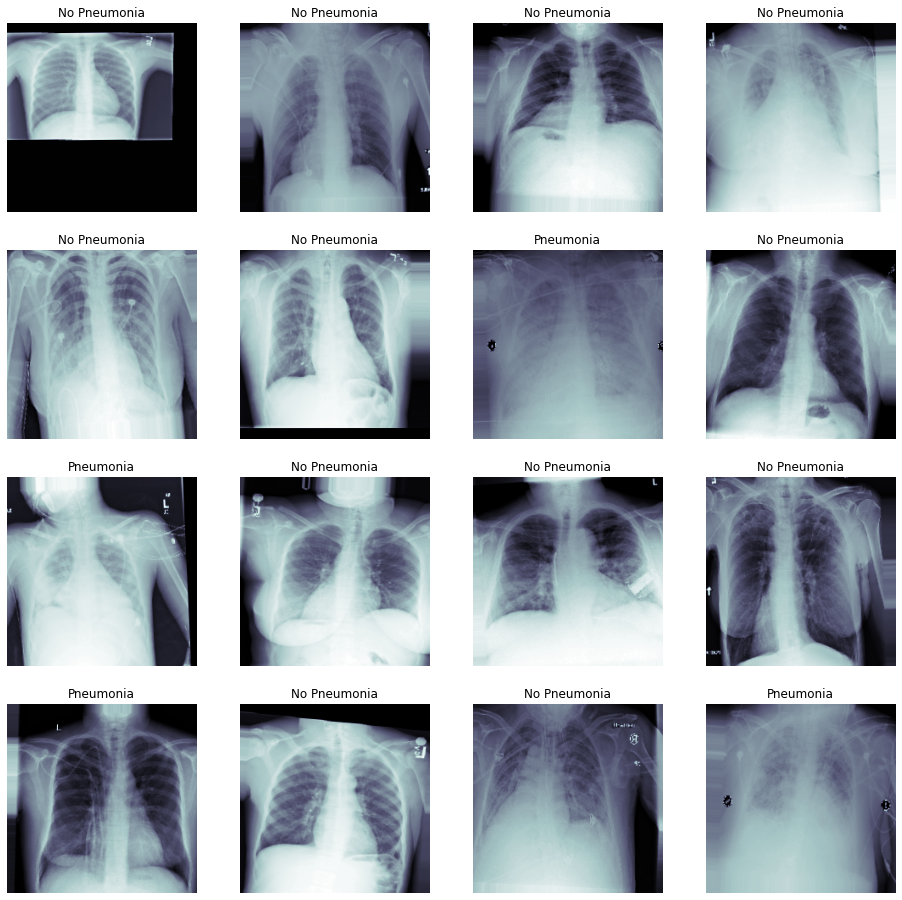

In [7]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen.train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
# train model a bit to find suitable learning rates
from source.model import load_pretrained_VGG16, load_pretrained_ResNet50, build_my_model
from source.train import find_optimal_lr, plot_lr_loss 
import os
find_new_suitable_lr = 0
optimallr_vgg16_path = os.path.join('output', 'optimallr_vgg16.csv')
optimallr_reasnet50_path = os.path.join('output', 'optimallr_resnet50.csv')
if find_new_suitable_lr:
    # find_optimal_lr vgg16  
    pretrained_vgg16 = load_pretrained_VGG16(lay_of_interest = 'block5_pool', trainable_after_layer = 17)
    vgg16 = build_my_model(pretrained_vgg16)
    find_optimal_lr(vgg16, train_gen, epochs = 20, save_path = os.path.join('output', 'optimallr_vgg16.csv'))
    
    # find_optimal_lr resnet50
    pretrained_resnet50 = load_pretrained_ResNet50(lay_of_interest = 'avg_pool', trainable_after_layer = 176)
    resnet50 = build_my_model(pretrained_resnet50, flatten_transfer_layer = False)
    find_optimal_lr(resnet50, train_gen, epochs = 20, save_path = os.path.join('output', 'optimallr_resnet50.csv'))

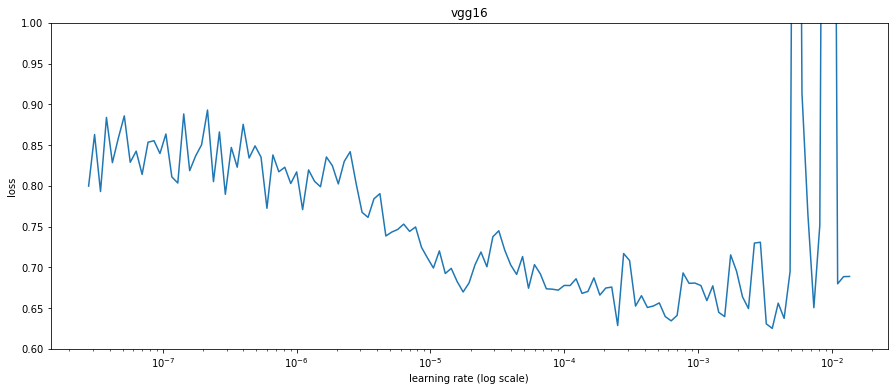

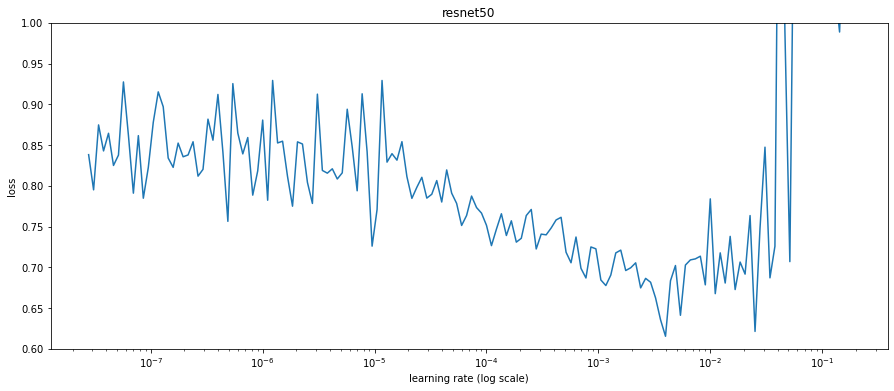

In [31]:
# Plot graphs to find suitable learning rates
plot_lr_loss(optimallr_vgg16_path, figure_title = 'vgg16', 
             n_skip_beginning=10, n_skip_end=5,
             outlier_cut = 100,
            plot_ylim = (0.6, 1) )
plot_lr_loss( optimallr_reasnet50_path, figure_title = 'resnet50', 
             n_skip_beginning=10, n_skip_end=5,
             outlier_cut = 100,
            plot_ylim = (0.6, 1) )

In [9]:
# From graph above, we can select lr range for each model
vgg16_lr_range = (4e-6, 2e-4)
resnet50_lr_range = (3e-5, 2e-3) 

In [10]:
from source.model import load_pretrained_VGG16, load_pretrained_ResNet50, build_my_model
from sklearn.metrics import precision_recall_curve
from source.train import TrainGen, make_val_gen
from source.train import build_callbacks_list
from source.train import train
import pandas as pd
import os

# read data
read_data_flag = 1
if read_data_flag:
    output_trainfile = os.path.join('processed_data', 'train_data.csv')
    output_valfile = os.path.join('processed_data', 'val_data.csv') 
    train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)
    train_gen = TrainGen(train_data)
    val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')


# vgg16 process
pretrained_vgg16 = load_pretrained_VGG16(lay_of_interest = 'block5_pool', trainable_after_layer = 17)
vgg16 = build_my_model(pretrained_vgg16)
model_name = 'vgg16'
weight_path = os.path.join('output', f"xray_class_{model_name}.best.hdf5")
callbacks_list = build_callbacks_list(weight_path = weight_path,
                                      validation_data = val_gen,
                                      patience = 10,
                                      initial_learning_rate = vgg16_lr_range[0],
                                      maximal_learning_rate = vgg16_lr_range[1],
                                      cyclical_lrstepsize = len(train_gen)*3)

with active_session():
    train(model = vgg16,
        callbacks_list = callbacks_list, 
        train_gen = train_gen, 
        #validation_data = val_gen,
        epochs = 40,
        save_architecture_to = os.path.join('output', f'my_{model_name}.json'),
        save_history_to = os.path.join('output', f'history_{model_name}.npy') )

Using TensorFlow backend.


Found 2304 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/40
9/9 [==============================] - 64s 7s/step - loss: 3.5476

Epoch 00001: PrecisionAtRecall80 improved from -inf to 0.23500, saving model to output/xray_class_vgg16.best.hdf5
Epoch 2/40
9/9 [==============================] - 35s 4s/step - loss: 2.3141

Epoch 00002: PrecisionAtRecall80 did not improve from 0.23500
Epoch 3/40
9/9 [==============================] - 39s 4s/step - loss: 1.0698

Epoch 00003: PrecisionAtRecall80 did not improve from 0.23500
Epoch 4/40
9/9 [==============================] - 40s 4s/step - loss: 0.7014

Epoch 00004: PrecisionAtRecall80 improved from 0.23500 to 0.23553, saving model to output/xray_class_vgg16.best.hdf5
Epoch 5/40
9/9 [==============================] - 39s 4s/step - loss: 0.7458

Epoch 00005: PrecisionAtRecall80 did not improve from 0.23553
Epoch 6/40
9/9 [==============================] - 39s 4s/step - loss: 0

In [11]:
from source.model import load_pretrained_VGG16, load_pretrained_ResNet50, build_my_model
from source.train import TrainGen, make_val_gen
from source.train import build_callbacks_list
from source.train import train
import pandas as pd
import os

# read data
read_data_flag = 1
if read_data_flag:
    output_trainfile = os.path.join('processed_data', 'train_data.csv')
    output_valfile = os.path.join('processed_data', 'val_data.csv') 
    train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)
    train_gen = TrainGen(train_data)
    val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')

# resnet50  process
pretrained_resnet50 = load_pretrained_ResNet50(lay_of_interest = 'avg_pool', trainable_after_layer = 176)
resnet50 = build_my_model(pretrained_resnet50, flatten_transfer_layer = False)
model_name = 'resnet50'
weight_path = os.path.join('output', f"xray_class_{model_name}.best.hdf5")
callbacks_list = build_callbacks_list(weight_path = weight_path,
                                      validation_data = val_gen,
                                      patience = 10,
                                      initial_learning_rate = resnet50_lr_range[0],
                                      maximal_learning_rate = resnet50_lr_range[1],
                                      cyclical_lrstepsize = len(train_gen)*3)
with active_session():
    train(model = resnet50,
            callbacks_list = callbacks_list, 
            train_gen = train_gen, 
            #validation_data = val_gen,
            epochs = 40,
            save_architecture_to = os.path.join('output', f'my_{model_name}.json'),
            save_history_to = os.path.join('output', f'history_{model_name}.npy') )

Found 2304 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/40
9/9 [==============================] - 62s 7s/step - loss: 0.7640

Epoch 00001: PrecisionAtRecall80 improved from -inf to 0.20194, saving model to output/xray_class_resnet50.best.hdf5
Epoch 2/40
9/9 [==============================] - 33s 4s/step - loss: 0.7462

Epoch 00002: PrecisionAtRecall80 did not improve from 0.20194
Epoch 3/40
9/9 [==============================] - 39s 4s/step - loss: 0.7189

Epoch 00003: PrecisionAtRecall80 did not improve from 0.20194
Epoch 4/40
9/9 [==============================] - 40s 4s/step - loss: 0.7041

Epoch 00004: PrecisionAtRecall80 did not improve from 0.20194
Epoch 5/40
9/9 [==============================] - 41s 5s/step - loss: 0.7024

Epoch 00005: PrecisionAtRecall80 did not improve from 0.20194
Epoch 6/40
9/9 [==============================] - 40s 4s/step - loss: 0.6932

Epoch 00006: PrecisionAtRecall80 did not impr

# Predict validation set and save

In [13]:
from source.predict import predict

# predict vgg16
model_name = 'vgg16'
model_path = os.path.join('output', f'my_{model_name}.json')
weight_path = os.path.join('output', f"xray_class_{model_name}.best.hdf5")
predict(model_path, weight_path, val_gen, 
        prediction_path = os.path.join('output', f"predval_{model_name}.npy"),
       groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy"))

# predict vgg16
model_name = 'resnet50'
model_path = os.path.join('output', f'my_{model_name}.json')
weight_path = os.path.join('output', f"xray_class_{model_name}.best.hdf5")
predict(model_path, weight_path, val_gen, 
        prediction_path = os.path.join('output', f"predval_{model_name}.npy"),
       groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy"))

6/6 [==============================] - 24s 4s/step


# Select best model with lowest validation loss and visualize some performance

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

/home/workspace/source/predict.py:106: RuntimeWarning: invalid value encountered in true_divide


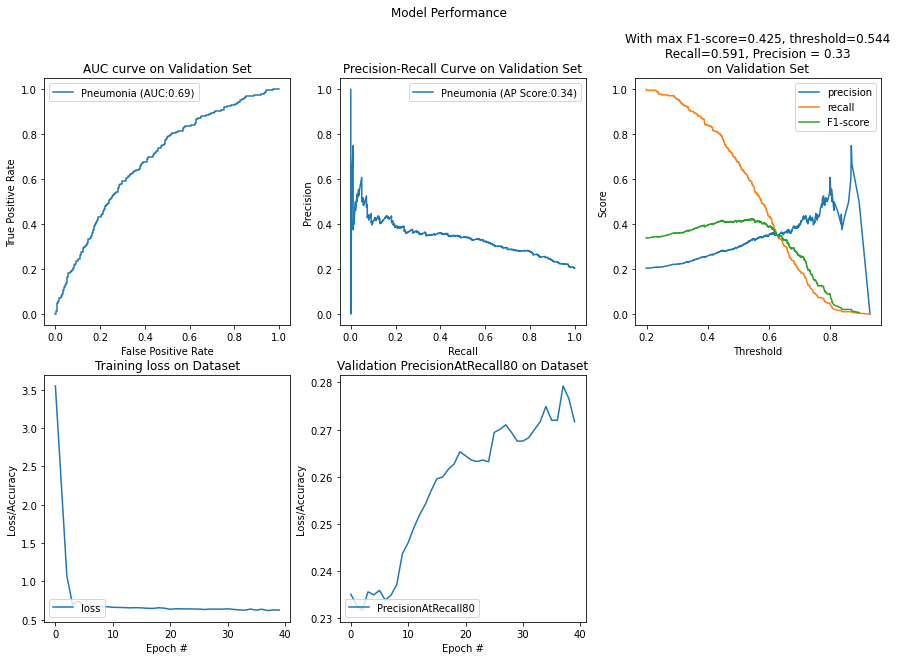

In [8]:
from source.predict import plot_auc, plot_history, calc_f1, plot_history
from source.predict import load_model, plot_performance
import os
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.


# see performance of vgg16   
best_model_name = 'vgg16'
model_name = best_model_name
prediction_path = os.path.join('output', f"predval_{model_name}.npy")
groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy")
plot_performance(prediction_path, groundtruth_path, 
                 history_path = os.path.join('output', f'history_{model_name}.npy'),
                 title = 'Model Performance')

# Load our our best model and look at some examples of true vs. predicted

In [24]:
from source.predict import load_model

# load best model
model_name = best_model_name
best_model =  load_model(model_path = os.path.join('output', f'my_{model_name}.json'), 
                   weight_path =  os.path.join('output', f"xray_class_{model_name}.best.hdf5"))

# Prepare examples of validation data
valX = []
valY = []
lenght = 0
while 1:
    this_valX, this_valY = val_gen.next()
    lenght += this_valY.shape[0]
    valX.append(this_valX)
    valY.append(this_valY)
    if lenght >= 100:
        break
valX = np.concatenate(valX)   
valY = np.concatenate(valY)

In [25]:
# get prediction
pred_Y = best_model.predict(valX, batch_size = 32, verbose = True).flatten()

256/256 [==============================] - 2s 9ms/step


In [102]:
import os
import numpy as np
from source.predict import precision_recall_curve, calc_f1
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
model_name =  'vgg16'
prediction_path = os.path.join('output', f"predval_{model_name}.npy")
groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy")
probability = np.load(prediction_path)
ground_truth = np.load(groundtruth_path)
precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
precision = precision[:-1]
recall = recall[:-1]
condition_index = (recall >= 0.8)
precision = precision[condition_index]
thresholds = thresholds[condition_index]
recall = recall[condition_index]
print(f'select thresholds = {thresholds[-1]:.2} with gives precision = {precision[-1]:.2}, recall = {recall[-1]:.2}, f1 = {calc_f1(precision[-1], recall[-1]):.2} ')
YOUR_THRESHOLD = thresholds[-1] # to have recall >= 0.8 

select thresholds = 0.44 with gives precision = 0.28, recall = 0.8, f1 = 0.41 


In [5]:
YOUR_THRESHOLD

0.44090602

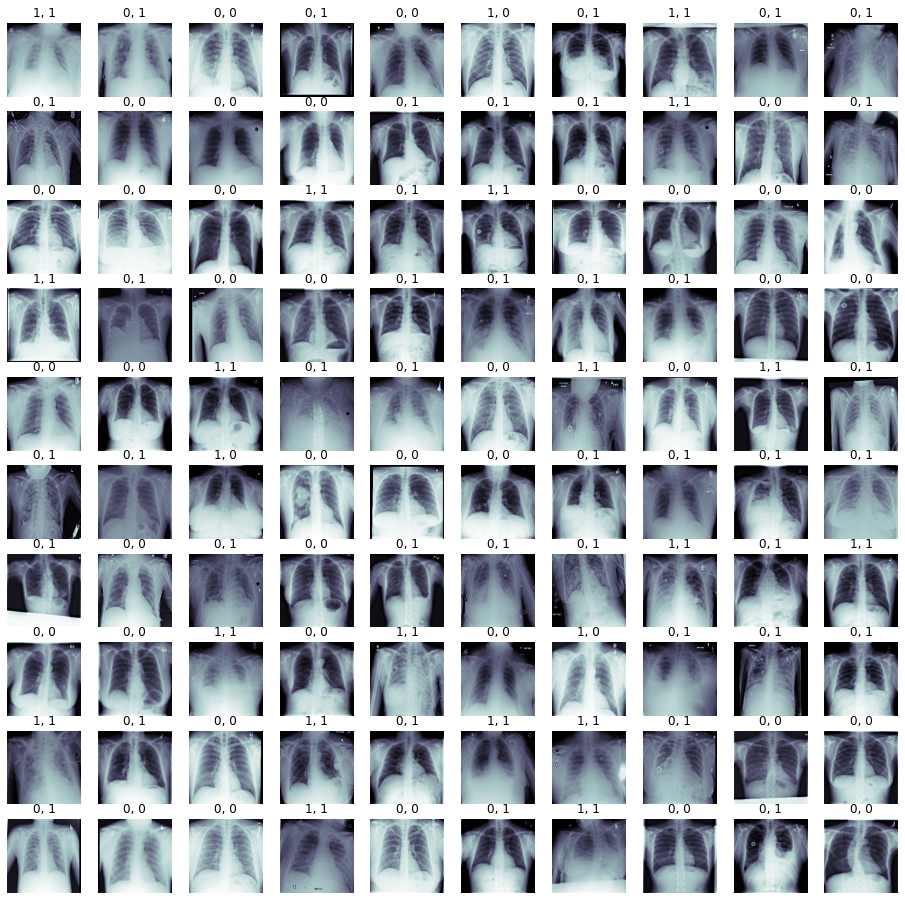

In [58]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] >= YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] >= YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

# Model performance in the presence of other diseases that comorbid with pneumonia

In [66]:
import pandas as pd

# load validation data
output_valfile = os.path.join('processed_data', 'val_data.csv') 
val_data = pd.read_csv(output_valfile)

# load prediction info
model_name =  'vgg16'
prediction_path = os.path.join('output', f"predval_{model_name}.npy")
probability = np.load(prediction_path)
val_data['Pneumonia_predict'] = probability
val_data['Image Index'] = val_data['path'].map(os.path.basename)
val_data = val_data[['Image Index', 'Pneumonia_predict']]
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df = all_xray_df[['Image Index', 'Finding Labels']]
all_xray_df['Finding Labels'] =  all_xray_df['Finding Labels'].str.split('|')
all_labels = all_xray_df['Finding Labels'].explode().unique()
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(set)
val_data = pd.merge(val_data, all_xray_df, on = 'Image Index')
for label in all_labels:
    val_data[label] = val_data['Finding Labels'].map(lambda x: 1 if label in x else 0)
val_data

,Image Index,Pneumonia_predict,Finding Labels,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00015485_003.png,0.354464,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00013641_045.png,0.611939,{Edema},0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,00016833_001.png,0.195667,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00018104_007.png,0.774369,{Edema},0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,00022235_011.png,0.676250,"{Mass, Atelectasis}",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,00018860_003.png,0.690739,{Atelectasis},0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1426,00026656_000.png,0.679765,"{Consolidation, Infiltration, Atelectasis, Eff...",0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
1427,00005064_001.png,0.644653,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1428,00010811_000.png,0.257714,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [99]:
from sklearn.metrics import precision_recall_fscore_support
from source.predict import calc_f1
performance = {'label': [], 'precision': [], 'recall': [], 'f1': [], 'num_cases': []}
for item in all_labels: 
    if (item == 'No Finding') | (item == 'Pneumonia'):
        continue
    subtable = val_data[val_data[item] == 1]
    y_pred = subtable.Pneumonia_predict.tolist()
    y_true = subtable.Pneumonia.tolist()  
    precision, recall, f1, support= precision_recall_fscore_support(y_true, np.asarray(y_pred) >= 0.44090602)    
    performance['label'].append(item)
    performance['precision'].append(precision[1])
    performance['recall'].append(recall[1])
    performance['f1'].append(f1[1])
    performance['num_cases'].append(sum(support))
performance = pd.DataFrame(performance)
performance = performance.sort_values('f1')
performance

,label,precision,recall,f1,num_cases
1,Emphysema,0.133333,0.800000,0.228571,37
6,Nodule,0.204545,0.642857,0.310345,72
8,Pneumothorax,0.220000,1.000000,0.360656,62
10,Fibrosis,0.222222,1.000000,0.363636,16
5,Mass,0.298246,0.894737,0.447368,77
0,Cardiomegaly,0.304348,1.000000,0.466667,28
7,Atelectasis,0.358333,0.716667,0.477778,163
2,Effusion,0.345912,0.887097,0.497738,186
9,Pleural_Thickening,0.343750,0.916667,0.500000,40
12,Consolidation,0.371429,0.896552,0.525253,81


In [103]:
performance[(performance.f1 < 0.41 )].sort_values('f1')

,label,precision,recall,f1,num_cases
1,Emphysema,0.133333,0.800000,0.228571,37
6,Nodule,0.204545,0.642857,0.310345,72
8,Pneumothorax,0.220000,1.000000,0.360656,62
10,Fibrosis,0.222222,1.000000,0.363636,16


In [104]:
performance[(performance.f1 > 0.41)].sort_values('f1')

,label,precision,recall,f1,num_cases
5,Mass,0.298246,0.894737,0.447368,77
0,Cardiomegaly,0.304348,1.000000,0.466667,28
7,Atelectasis,0.358333,0.716667,0.477778,163
2,Effusion,0.345912,0.887097,0.497738,186
9,Pleural_Thickening,0.343750,0.916667,0.500000,40
12,Consolidation,0.371429,0.896552,0.525253,81
4,Infiltration,0.453782,0.892562,0.601671,316
11,Edema,0.787500,0.984375,0.875000,83
3,Hernia,1.000000,1.000000,1.000000,2


The presence of Emphysema or Nodule may reduce the model performance of the algorithm in accurately predicting the presence of pneumonia in a chest x-ray. Conversely, the presence of Edema, Infiltration, or Consolidation in the image may lead to improved performance of the algorithm at accurately predicting the presence of pneumonia from a chest x-ray.

# Show model achitecture

In [6]:
from source.predict import load_model
import os
model_name = 'vgg16'
model =  load_model(model_path = os.path.join('output', f'my_{model_name}.json'), 
                   weight_path =  os.path.join('output', f"xray_class_{model_name}.best.hdf5"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


In [7]:
model.get_layer('model_1').summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   